In [1]:
import keras_nlp
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
VOCAB_SIZE = 10000
MAX_LEN = 2000
EMBED_DIM = 128
INTERMEDIATE_DIM = 512

TYPE = 'F/T'

In [3]:
data1 = pd.read_csv ('lemmatized-bestTranslate.csv')
data1.head ()

,E/I,N/S,F/T,P/J,lemmatized
0,True,False,False,True,youtubevideo imglink enfp и intj момент youtub...
1,False,False,True,False,я очень тревожить отсутствие я в этот пост . с...
2,True,False,True,False,"хороший _ youtubevideo конечно , на что я гово..."
3,True,False,True,True,"уважаемый intp , я понравиться наш вчерашний р..."
4,False,False,True,True,вы уволить . это еще один глупый заблуждение ....


In [6]:
type1 = TYPE
if data1.__contains__ ('Unnamed: 0'):
    data1 = data1.drop (columns = ['Unnamed: 0'])
types = ['E/I', 'N/S', 'F/T', 'P/J']
types.remove (type1)
data1 = data1.drop (columns = types)

false = data1 [data1 [type1] == False]
true = data1 [data1 [type1] == True]
if (len (false) < len (true)):
    true = true.sample (n = len (false), random_state = 0)
else:
    false = false.sample (n = len (true), random_state = 0)
data1 = pd.concat ([false, true], axis = 0)

'''max_size = data1 [type1].value_counts ().max ()
lst = [data1]
for class_index, group in data1.groupby (type1):
    lst.append (group.sample (max_size - len (group), replace = True, random_state = 0))
data1 = pd.concat (lst)'''

'''false = data1 [data1 [type1] == False]
true = data1 [data1 [type1] == True]
if (len (false) < len (true)):
    balance = (len (true) - len (false)) // 2
    true = true.sample (n = len (true) - balance, random_state = 0)
    false = false.sample (n = len (false) + balance, replace = True, random_state = 0)
else:
    balance = (len (false) - len (true)) // 2
    false = false.sample (n = len (false) - balance, random_state = 0)
    true = true.sample (n = len (true) + balance, replace = True, random_state = 0)
data1 = pd.concat ([false, true], axis = 0)'''

data = data1 ['lemmatized']
labels = data1 [type1]

In [7]:
trainData, testData, trainLabels, testLabels = train_test_split (data, labels, train_size = 0.8, random_state = 0)
valData, testData, valLabels, testLabels = train_test_split (testData, testLabels, train_size = 0.5, random_state = 0)

In [8]:
encoder = tf.keras.layers.TextVectorization (max_tokens = VOCAB_SIZE, standardize = 'lower')
encoder.adapt (trainData)

In [9]:
trainData = encoder (trainData)
valData = encoder (valData)
testData = encoder (testData)

In [10]:
trainData = tf.keras.preprocessing.sequence.pad_sequences(trainData, maxlen=MAX_LEN)
valData = tf.keras.preprocessing.sequence.pad_sequences(valData, maxlen=MAX_LEN)
testData = tf.keras.preprocessing.sequence.pad_sequences(testData, maxlen=MAX_LEN)

In [13]:
input_ids = tf.keras.Input(shape=(None,))

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

fnet_classifier = tf.keras.Model(input_ids, outputs)

In [14]:
fnet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
    loss=tf.keras.losses.BinaryCrossentropy (),
    metrics=["accuracy"],)
h = fnet_classifier.fit(trainData, trainLabels, epochs=30, validation_data=(valData, valLabels), batch_size = 10, shuffle = True)

Epoch 1/30
637/637 [==============================] - 38s 53ms/step - loss: 0.6946 - accuracy: 0.5021 - val_loss: 0.6923 - val_accuracy: 0.5113
Epoch 2/30
637/637 [==============================] - 35s 55ms/step - loss: 0.6918 - accuracy: 0.5232 - val_loss: 0.6899 - val_accuracy: 0.5126
Epoch 3/30
637/637 [==============================] - 34s 53ms/step - loss: 0.6873 - accuracy: 0.5434 - val_loss: 0.7032 - val_accuracy: 0.5113
Epoch 4/30
637/637 [==============================] - 35s 54ms/step - loss: 0.6823 - accuracy: 0.5736 - val_loss: 0.6820 - val_accuracy: 0.6294
Epoch 5/30
637/637 [==============================] - 36s 56ms/step - loss: 0.6697 - accuracy: 0.6326 - val_loss: 0.6739 - val_accuracy: 0.5955
Epoch 6/30
637/637 [==============================] - 37s 58ms/step - loss: 0.6432 - accuracy: 0.7017 - val_loss: 0.6365 - val_accuracy: 0.6470
Epoch 7/30
637/637 [==============================] - 37s 57ms/step - loss: 0.5930 - accuracy: 0.7458 - val_loss: 0.5779 - val_accuracy:

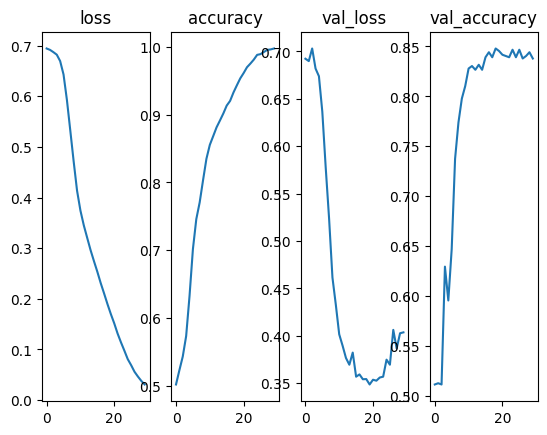

In [15]:

figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

histx = np.arange(0, len(h.history['loss']), 1)
ax1.plot(histx, h.history['loss'])
ax1.set_title("loss")

histx = np.arange(0, len(h.history['accuracy']), 1)
ax2.plot(histx, h.history['accuracy'])
ax2.set_title("accuracy")

histx = np.arange(0, len(h.history['val_loss']), 1)
ax3.plot(histx, h.history['val_loss'])
ax3.set_title("val_loss")

histx = np.arange(0, len(h.history['val_accuracy']), 1)
ax4.plot(histx, h.history['val_accuracy'])
ax4.set_title("val_accuracy")

plt.show ()

25/25 [==============================] - 2s 47ms/step
Accuracy:  0.8431618569636136
Precision:  0.8980169971671388
Recall:  0.7807881773399015
F1:  0.8353096179183135


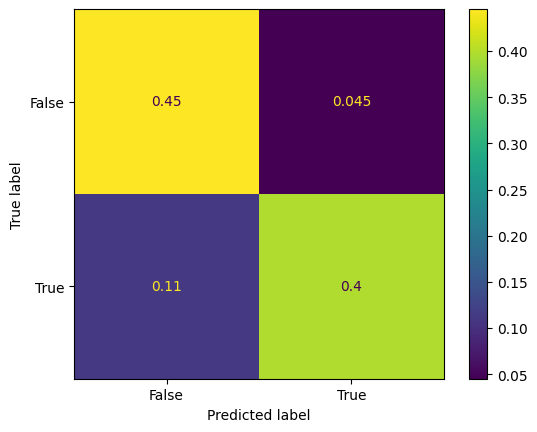

In [16]:
def showMetrics (model, data1, labels1, threshold = False):
    prediction = model.predict (data1)
    if (threshold):
        preds = []
        for i in prediction:
            preds.append (i [0] >= 0.5)
        prediction = preds
    print ('Accuracy: ', accuracy_score (labels1, prediction))
    print ('Precision: ', precision_score (labels1, prediction))
    print ('Recall: ', recall_score (labels1, prediction))
    print ('F1: ', f1_score (labels1, prediction))
    ConfusionMatrixDisplay.from_predictions (labels1, prediction, normalize = 'all')
showMetrics (fnet_classifier, testData, testLabels, threshold = True)